# Tellurify
**Objective: Convert an input PDB volume into a Telluroienylalanine-substituted PDB**

**Algorithm**
1. Read groups of phenylalanine ATOM records from a PDB.
2. For each group, get CB, CG, CB->CG vector, and dihedral angle CA-CB:CG:CD1
3. Delete all atoms after CB, insert tellurienyl ring and calculate the new dihedral
4. Rotate the tellurienyl ring about the CB:CG axis until the dihedral is as desired.

Need to think about how we're going to encode the tellurienyl ring.
We want something where we can just offset the coordinates of the atoms by the coordinates of CB and have it 

When we insert the ring, we will be creating the BG bond.
This bond needs to be a vector parallel and with the same origin as the old BG bond.

1. Define a rigid body CB-CG-CD-CE-CZ-Te-(CG) (the ring plus a stub)
2. Find a rotation (axis must be through CB/origin) that translates vector BG to have the same slope of old vector BG (same 3d slope).
3. Find a translation that moves CB onto initial CB

https://www.euclideanspace.com/maths/geometry/rotations/conversions/angleToQuaternion/index.htm

https://stackoverflow.com/questions/4870393/rotating-coordinate-system-via-a-quaternion

https://stackoverflow.com/questions/1171849/finding-quaternion-representing-the-rotation-from-one-vector-to-another


https://bitbucket.org/sinbad/ogre/src/9db75e3ba05c/OgreMain/include/OgreVector3.h#cl-651

In [29]:
import sys
import copy
import math

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from Bio.PDB import *
import nglview as nv # molecular graphics viewing system !?

%matplotlib notebook
mpl.rcParams['figure.dpi'] = 100
plt.style.use(['dark_background'])

In [40]:
def coordsOfAtomFromResidue(atomName, resi):
    return [a for a in resi.get_atoms() if a.get_name() == atomName][0].get_coord()

def quatConj(q):
    # Compute the conjugate of quaternion q
    return [q[0], -1*q[1], -1*q[2], -1*q[3]]

def quatMult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def quatToRotateAontoB(a,b):
    theta = np.arccos(np.dot(a,b))
    axis = normalize(np.cross(a, b))
    s = np.sin(theta/2)
    q = [np.cos(theta/2), axis[0]*s, axis[1]*s, axis[2]*s]
    q = q / np.linalg.norm(q)
    return q

def transformVectorByQuaternion(v, q):
    # Transform a 3d vector by quaternion q, and return a 3D vector
    vq = [0, v[0], v[1], v[2]]
    transformed = quatMult(quatMult(q, vq), quatConj(q))
    
    return [transformed[1], transformed[2], transformed[3]]
    
def normalize(v):
    norm = np.linalg.norm(v)
    return v / norm

In [41]:
# Import data from the PDB
parser = PDBParser()
structure = parser.get_structure('vrk1', '6ac9.pdb')

F = [r for r in structure[0]['A'] if r.get_resname() == "PHE"]

print("Loaded PDB and found %d phenylalanines." % len(F))

# Get the TePhe rigid body
tephe_structure = parser.get_structure('tephe', 'tephe.pdb')
tephe_resi = list(tephe_structure[0].get_residues())[0]

# Make a dictionary with all the necessary TePhe atoms (ring plus beta carbon)
tephe = {
    'CB' : coordsOfAtomFromResidue('CB',tephe_resi),
    'CG' : coordsOfAtomFromResidue('CG',tephe_resi),
    'CD' : coordsOfAtomFromResidue('CD',tephe_resi),
    'CE' : coordsOfAtomFromResidue('CE',tephe_resi),
    'CZ' : coordsOfAtomFromResidue('CZ',tephe_resi),
    'Te' : coordsOfAtomFromResidue('Te',tephe_resi)
}
    
# Keep track of the coordinates for each TePHe
tephes = []

# Iterate through the phenylalanines
for f in F:    
    # Get the PHE atomic coordinates needed to position the new TEPHE ring.
    phe = {
        'CA' : coordsOfAtomFromResidue('CA',f),
        'CB' : coordsOfAtomFromResidue('CB',f),
        'CG' : coordsOfAtomFromResidue('CG',f),
        'CD1' : coordsOfAtomFromResidue('CD1',f),
        'CD2' : coordsOfAtomFromResidue('CD2',f),
        'CE1' : coordsOfAtomFromResidue('CE1',f),
        'CE2' : coordsOfAtomFromResidue('CE2',f),
        'CZ' : coordsOfAtomFromResidue('CZ',f)
    }
    
    # Find the stem vectors between beta and gamma carbons
    tBG = normalize(np.subtract(tephe['CG'],tephe['CB']))
    pBG = normalize(np.subtract(phe['CG'],phe['CB']))

    # Calculate the quaternion rotation that makes tBG parallel to pBG
    q = quatToRotateAontoB(tBG, pBG)

    # Apply the quaternion rotation to the tephe points
    for key,value in tephe.items():
        tephe[key] = transformVectorByQuaternion(value, q)
    
    # Measure the dihedral angle between pAB and pGD1 (rotation of the BD bond)
    pAB = normalize(np.subtract(phe['CB'], phe['CA']))
    pGD = normalize(np.subtract(phe['CD1'], phe['CG']))
    phe_dihedral = np.arccos(np.dot(pAB,pGD))
    
    # Measure the dihedral angle between pATb and tGD1
    pAtB = normalize(np.subtract(tephe['CB'], phe['CA']))
    tGD = normalize(np.subtract(tephe['CD'], tephe['CG']))
    
    tephe_dihedral = np.arccos(np.dot(pAtB, tGD))
    
    # Rotate the TePhe ring by the difference in dihedral angles about the BG axis
    theta = tephe_dihedral-phe_dihedral
    axis = normalize(tBG)
    s = np.sin(theta/2)
    q = [np.cos(theta/2), axis[0]*s, axis[1]*s, axis[2]*s]
    q = q / np.linalg.norm(q)
    
    # Apply the quaternion rotation to the tephe points
    for key,value in tephe.items():
        tephe[key] = transformVectorByQuaternion(value, q)
    
    # Translate the ring so that tCB aligns with pCB
    translation = np.subtract(phe['CB'],tephe['CB'])
    for key,value in tephe.items():
        tephe[key] = np.add(value, translation)
        
    
    # Append
    tephes.append(copy.deepcopy(tephe))
    


<IPython.core.display.Javascript object>


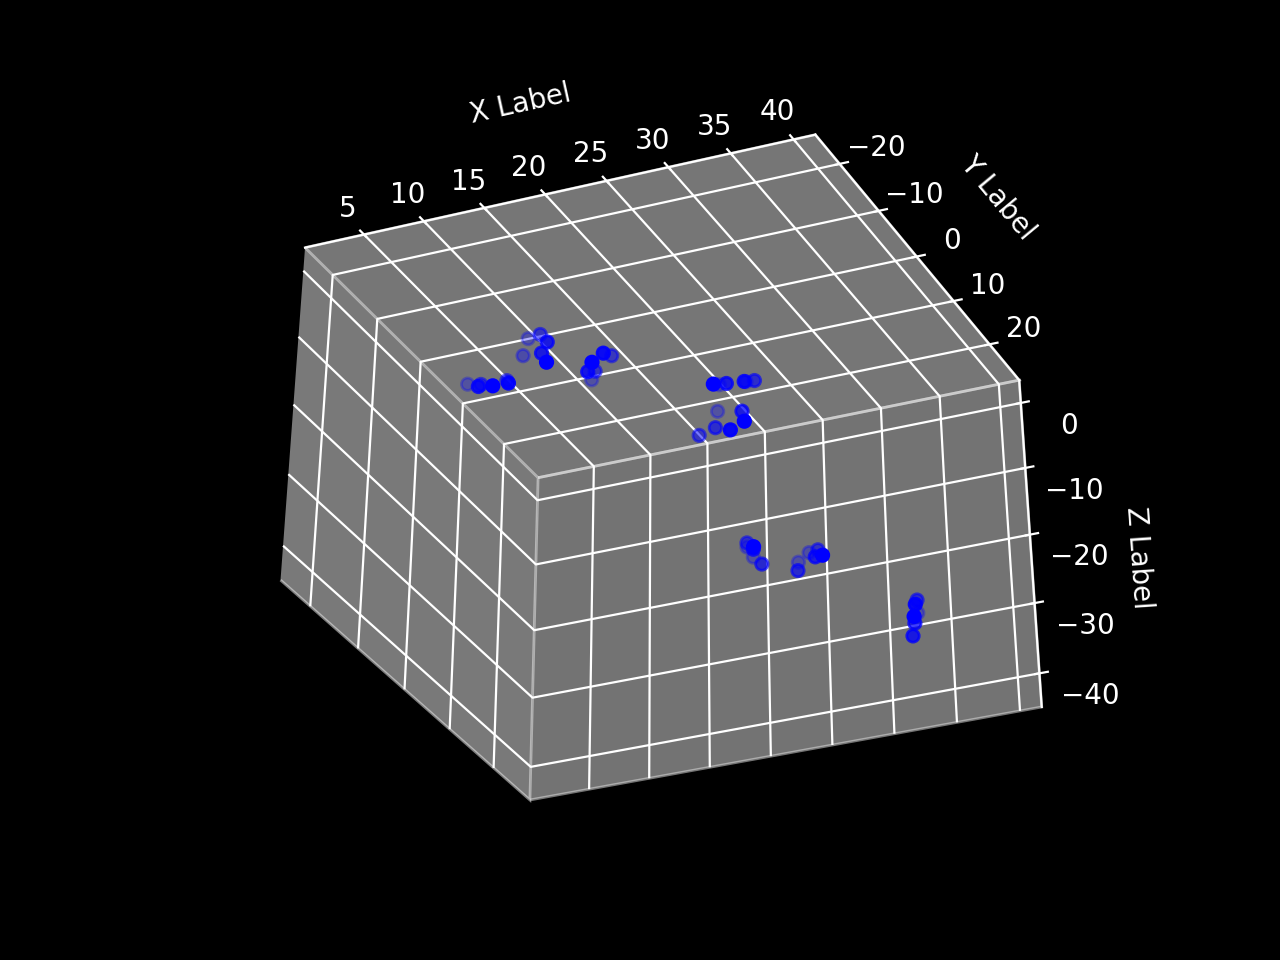

In [44]:
def plotDictionaryOnAxes(ax, d, color):
    xs = [v[0] for k,v in d.items()]
    ys = [v[1] for k,v in d.items()]
    zs = [v[2] for k,v in d.items()]
    ax.scatter(xs, ys, zs, color=color)

from mpl_toolkits.mplot3d import Axes3D  
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection="3d")

for t in tephes:
    plotDictionaryOnAxes(ax, t,"b")

# plotDictionaryOnAxes(ax, phe,"r")
# plotDictionaryOnAxes(ax, tephe,"b")

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [51]:
tephe

{'CB': array([ 6.25400019, -5.32700014, -5.78000021]),
 'CG': array([ 6.899344  , -5.38200444, -4.42793221]),
 'CD': array([ 7.39365485, -6.49051779, -3.79898845]),
 'CE': array([ 7.91366725, -6.35749269, -2.47039563]),
 'CZ': array([ 7.89068296, -5.12751387, -1.88510558]),
 'Te': array([ 7.07265033, -3.71290384, -3.1644597 ])}